# 📊 교육 수준에 따른 흡연율 상관관계 분석

**담당자:** 오흥재  
**목표:** 교육 수준(sob_01z1)과 흡연율(sma_03z2) 간의 상관관계 파악

---

## 📋 분석 계획

### 1️⃣ **데이터 준비**
- 교육수준(sob_01z1) 변수 확인
- 흡연상태(sma_03z2) 변수 확인
- 결측치 및 이상치 처리

### 2️⃣ **탐색적 데이터 분석 (EDA)**
- 교육수준별 분포
- 흡연상태별 분포
- 교육수준 × 흡연상태 교차표

### 3️⃣ **상관관계 분석**
- 교육수준별 흡연율 계산
- 시각화 (막대그래프, 히트맵)
- 통계적 검정 (카이제곱 검정)

### 4️⃣ **인사이트 도출**
- 주요 발견사항
- 모델링 시사점

In [34]:
# 환경 설정
import sys
import os
project_root = os.path.abspath('../../..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import matplotlib.font_manager as fm

# Variable Decoder 최신 버전 (fallback 지원)
from notebooks.vfxpedia.utils.variable_decoder import (
    VariableDecoder,
    get_korean_label,
    get_korean_labels,
    create_korean_labels_dict
)

# 팀 시각화 스타일
try:
    font_path = "C:/Windows/Fonts/HMFMMUEX.TTC"
    if os.path.exists(font_path):
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    else:
        plt.rcParams['font.family'] = 'Malgun Gothic'
except:
    plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 팀 컬러
TEAM_COLORS = {
    'primary': '#1f77b4',
    'success': '#ff7f0e',
    'danger': '#1f77b4',
    'palette': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
}

print('✅ 환경 설정 완료!')

✅ 환경 설정 완료!


## 📂 Step 1: 데이터 로드 및 변수 디코딩

In [15]:
# 데이터 로드
df = pd.read_csv('../output/analy_data_cleaned.csv')
decoder = VariableDecoder()

print(f'전체 데이터: {df.shape}')
print(f'\n핵심 변수 존재 확인:')
print(f"  - sob_01z1 (교육수준): {'✅' if 'sob_01z1' in df.columns else '❌'}")
print(f"  - sma_03z2 (흡연상태): {'✅' if 'sma_03z2' in df.columns else '❌'}")
print(f"  - churn (타겟): {'✅' if 'churn' in df.columns else '❌'}")

✅ variable.csv 로드 완료: 709 개 매핑
✅ variable_full.csv 로드 완료: 681 개 매핑 (fallback)
전체 데이터: (89757, 210)

핵심 변수 존재 확인:
  - sob_01z1 (교육수준): ✅
  - sma_03z2 (흡연상태): ✅
  - churn (타겟): ✅


In [16]:
# 변수 디코딩
df_work = df.copy()

# apply 방식으로 디코딩
df_work['sob_01z1_decoded'] = df_work['sob_01z1'].apply(lambda x: decoder.decode_value('sob_01z1', x))
df_work['sma_03z2_decoded'] = df_work['sma_03z2'].apply(lambda x: decoder.decode_value('sma_03z2', x))

# 변수 라벨 확인
print(f"sob_01z1: {get_korean_label('sob_01z1')}")  # "교육수준"
print(f"sma_03z2: {get_korean_label('sma_03z2')}")  # "일반담배현재흡연상태"


# 디코딩 결과 확인
print('✅ 디코딩 완료!')
df_work[['sob_01z1', 'sob_01z1_decoded', 'sma_03z2', 'sma_03z2_decoded', 'churn']].head(10)

sob_01z1: 교육수준
sma_03z2: 일반담배현재흡연상태
✅ 디코딩 완료!


,sob_01z1,sob_01z1_decoded,sma_03z2,sma_03z2_decoded,churn
0,7.0,4년제대학,3.0,과거피웠으나현재금연,1
1,5.0,고등학교,1.0,매일피움,0
2,6.0,2년3년제대학,3.0,과거피웠으나현재금연,1
3,7.0,4년제대학,1.0,매일피움,0
4,3.0,초등학교,1.0,매일피움,0
5,3.0,초등학교,3.0,과거피웠으나현재금연,1
6,7.0,4년제대학,3.0,과거피웠으나현재금연,1
7,7.0,4년제대학,3.0,과거피웠으나현재금연,0
8,8.0,대학원이상,3.0,과거피웠으나현재금연,1
9,5.0,고등학교,3.0,과거피웠으나현재금연,1


## 🔍 Step 2: 탐색적 데이터 분석 (EDA)

=== 교육수준 분포 ===
고등학교       31354
4년제대학      21714
2년3년제대학    11169
중학교        10376
초등학교        9896
대학원이상       3731
무학          1463
서당한학          54
Name: count, dtype: int64


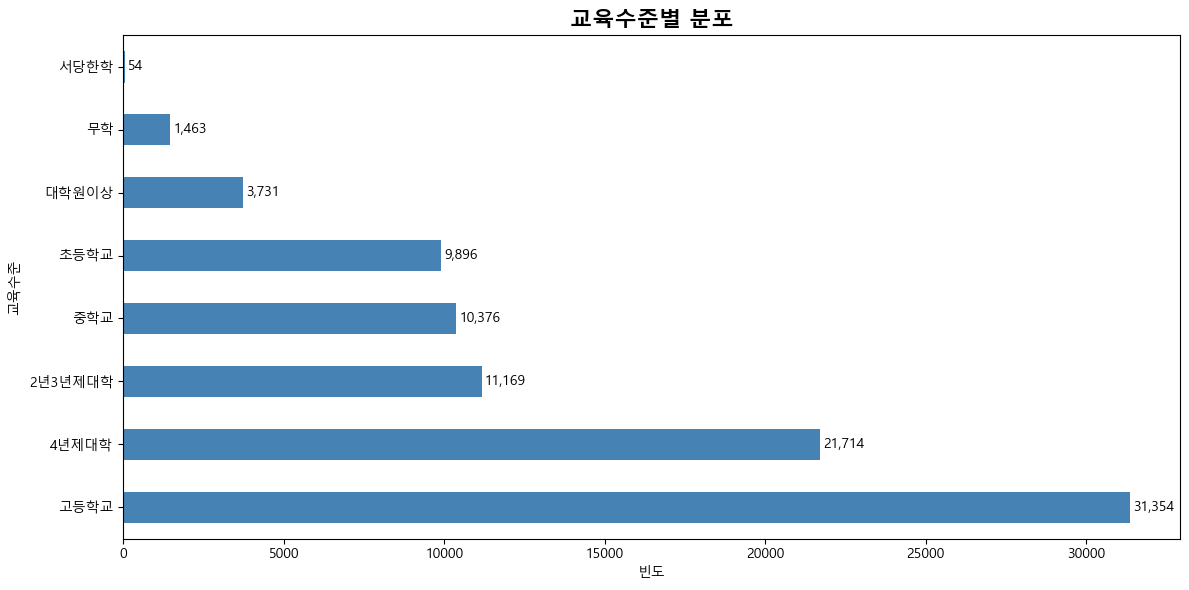

In [17]:
# 교육수준 분포
print('=== 교육수준 분포 ===')
edu_dist = decoder.create_value_counts_decoded(df_work, 'sob_01z1')
print(edu_dist)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))
edu_dist.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('교육수준별 분포', fontsize=16, fontweight='bold')
ax.set_xlabel('빈도')
ax.set_ylabel('교육수준')

# 막대 위에 값 표시
for i, v in enumerate(edu_dist):
    ax.text(v + 100, i, f'{v:,}', va='center')

plt.tight_layout()
plt.show()


=== 흡연상태 분포 ===
과거피웠으나현재금연    52026
매일피움          33774
가끔피움           3593
비해당             328
모름               36
Name: count, dtype: int64


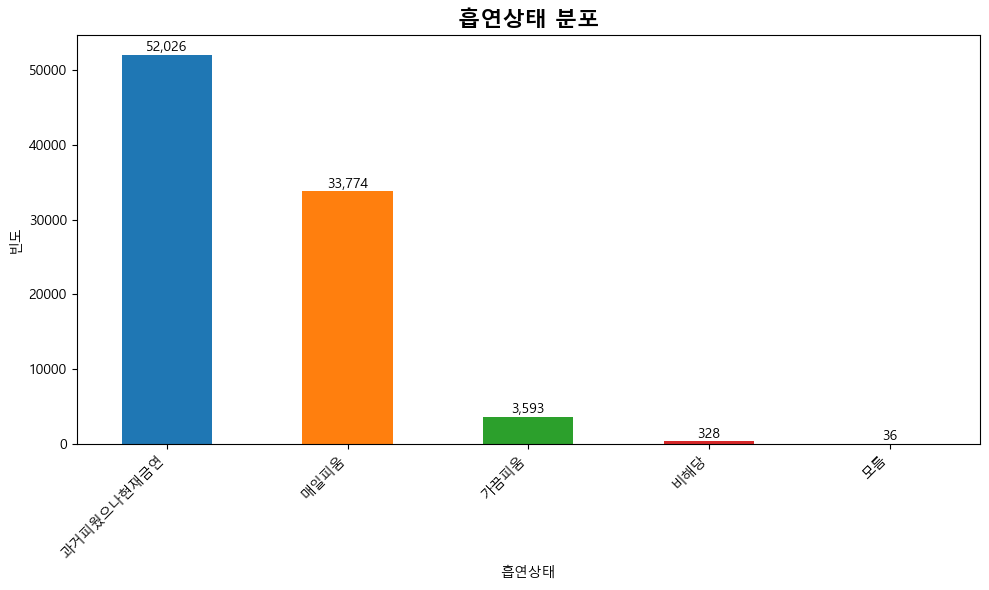

In [20]:
# 흡연상태 분포
print('\n=== 흡연상태 분포 ===')
smoke_dist = decoder.create_value_counts_decoded(df_work, 'sma_03z2')
print(smoke_dist)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
smoke_dist.plot(kind='bar', ax=ax, color=TEAM_COLORS['palette'])
ax.set_title('흡연상태 분포', fontsize=16, fontweight='bold')
ax.set_xlabel('흡연상태')
ax.set_ylabel('빈도')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(smoke_dist):
    ax.text(i, v + 500, f'{v:,}', ha='center')

plt.tight_layout()
plt.show()

## 📊 Step 3: 교차분석 (교육수준 × 흡연상태)

In [21]:
# 교차표 생성
crosstab = pd.crosstab(
    df_work['sob_01z1_decoded'], 
    df_work['sma_03z2_decoded'],
    margins=True
)

print('=== 교육수준 × 흡연상태 교차표 ===')
crosstab

=== 교육수준 × 흡연상태 교차표 ===


sma_03z2_decoded,가끔피움,과거피웠으나현재금연,매일피움,모름,비해당,All
sob_01z1_decoded,,,,,,
2년3년제대학,601,5627,4862,7,72,11169
4년제대학,1110,12867,7594,7,136,21714
고등학교,1122,16225,13903,12,92,31354
대학원이상,206,2729,786,0,10,3731
무학,32,1016,412,1,2,1463
서당한학,1,42,11,0,0,54
중학교,312,6580,3467,5,12,10376
초등학교,209,6940,2739,4,4,9896
All,3593,52026,33774,36,328,89757


In [22]:
# 비율로 변환 (행 기준)
crosstab_pct = pd.crosstab(
    df_work['sob_01z1_decoded'], 
    df_work['sma_03z2_decoded'],
    normalize='index'
) * 100

print('\n=== 교육수준별 흡연상태 비율 (%) ===')
crosstab_pct.round(2)


=== 교육수준별 흡연상태 비율 (%) ===


sma_03z2_decoded,가끔피움,과거피웠으나현재금연,매일피움,모름,비해당
sob_01z1_decoded,,,,,
2년3년제대학,5.38,50.38,43.53,0.06,0.64
4년제대학,5.11,59.26,34.97,0.03,0.63
고등학교,3.58,51.75,44.34,0.04,0.29
대학원이상,5.52,73.14,21.07,0.00,0.27
무학,2.19,69.45,28.16,0.07,0.14
서당한학,1.85,77.78,20.37,0.00,0.00
중학교,3.01,63.42,33.41,0.05,0.12
초등학교,2.11,70.13,27.68,0.04,0.04


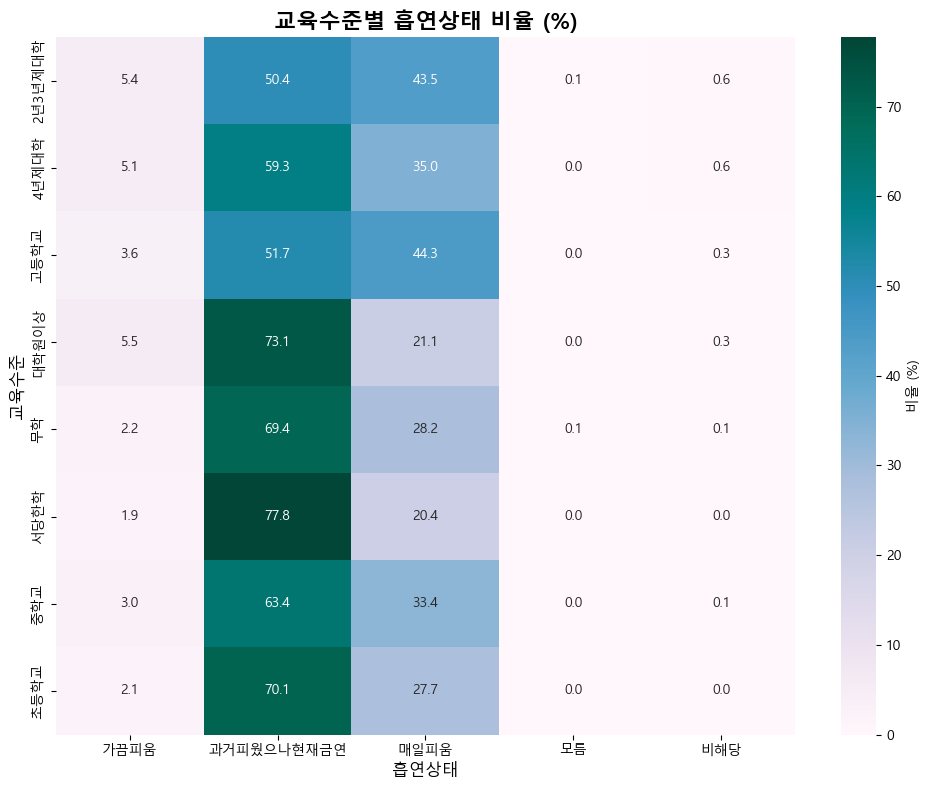

In [26]:
# 히트맵 시각화
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='PuBuGn', 
            cbar_kws={'label': '비율 (%)'}, ax=ax)
ax.set_title('교육수준별 흡연상태 비율 (%)', fontsize=16, fontweight='bold')
ax.set_xlabel('흡연상태', fontsize=12)
ax.set_ylabel('교육수준', fontsize=12)
plt.tight_layout()
plt.show()

## 🎯 Step 4: 교육수준별 흡연율 계산

In [28]:
# 현재 흡연자만 필터링 (매일 + 가끔)
# sma_03z2: 1=매일피운다, 2=가끔피운다, 3=과거피웠으나현재안피움

# 교육수준별 현재 흡연율 계산
smoking_rate = df_work.groupby('sob_01z1_decoded').apply(
    lambda x: (x['sma_03z2'].isin([1.0, 2.0])).sum() / len(x) * 100
).sort_values(ascending=False)

print('=== 교육수준별 현재 흡연율 (%) ===')
print(smoking_rate.round(2))

=== 교육수준별 현재 흡연율 (%) ===
sob_01z1_decoded
2년3년제대학    48.91
고등학교       47.92
4년제대학      40.08
중학교        36.42
무학         30.35
초등학교       29.79
대학원이상      26.59
서당한학       22.22
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_90648\2775999817.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smoking_rate = df_work.groupby('sob_01z1_decoded').apply(


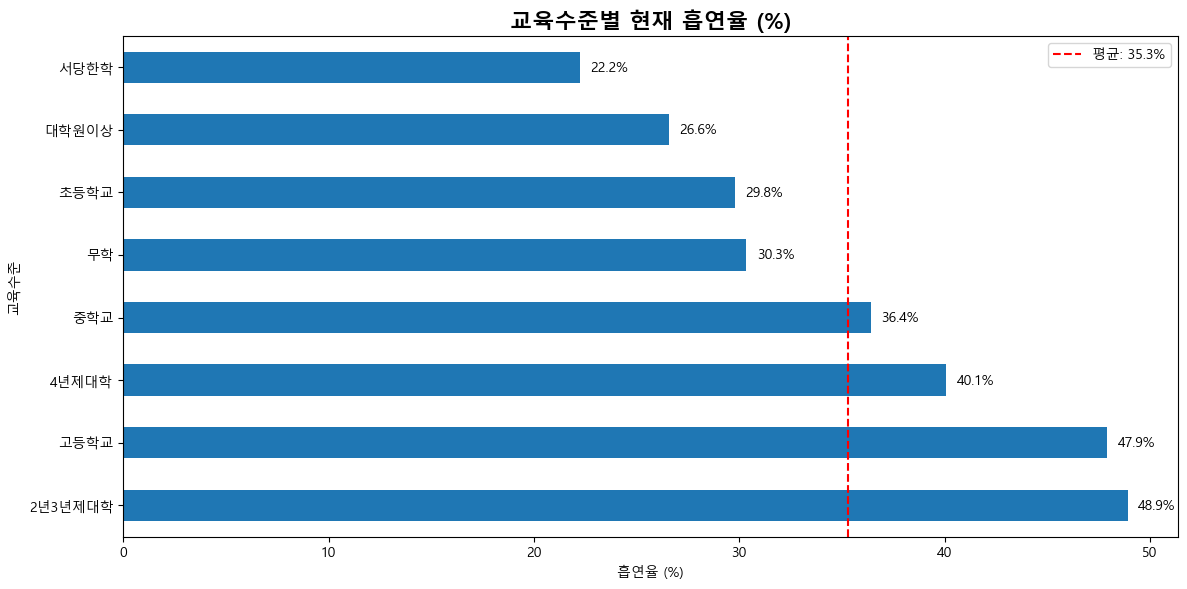

In [33]:
# 흡연율 시각화
fig, ax = plt.subplots(figsize=(12, 6))
smoking_rate.plot(kind='barh', ax=ax, color=TEAM_COLORS['danger'])
ax.set_title('교육수준별 현재 흡연율 (%)', fontsize=16, fontweight='bold')
ax.set_xlabel('흡연율 (%)')
ax.set_ylabel('교육수준')
ax.axvline(smoking_rate.mean(), color='red', linestyle='--', label=f'평균: {smoking_rate.mean():.1f}%')
ax.legend()

for i, v in enumerate(smoking_rate):
    ax.text(v + 0.5, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

## 📈 Step 5: 통계적 검정 (카이제곱 검정)

### 카이제곱 검정
    H0: 교육수준과 흡연상태는 독립이다 (상관관계 없음)
    H1: 교육수준과 흡연상태는 독립이 아니다 (상관관계 있음)

In [40]:
# 교육수준 × 금연성공 관계
crosstab = pd.crosstab(df['sob_01z1'], df['churn'])
chi2, p_value, dof, expected = chi2_contingency(crosstab)

print('=== 카이제곱 검정 결과 ===')
print(f"카이제곱 통계량: {chi2:.4f}")
print(f"p-value: {p_value:.4f}")

print(f'\n결론: ', end='')
if p_value < 0.05:
    print("✅ 교육수준과 금연성공은 관련이 있습니다! (p < 0.05)")
else:
    print("❌ 유의미한 관계가 없습니다 (p ≥ 0.05)")

=== 카이제곱 검정 결과 ===
카이제곱 통계량: 2351.8658
p-value: 0.0000

결론: ✅ 교육수준과 금연성공은 관련이 있습니다! (p < 0.05)


In [38]:
# 교육수준 × 흡흡연성공 관계


contingency_table = pd.crosstab(df_work['sob_01z1_decoded'], df_work['sma_03z2_decoded'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('=== 카이제곱 검정 결과 ===')
print(f'카이제곱 통계량: {chi2:.2f}')
print(f'p-value: {p_value:.4e}')
print(f'자유도: {dof}')
print(f'\n결론: ', end='')
if p_value < 0.05:
    print('✅ 교육수준과 흡연상태는 통계적으로 유의한 상관관계가 있습니다 (p < 0.05)')
else:
    print('❌ 교육수준과 흡연상태 간 유의한 상관관계를 발견하지 못했습니다 (p ≥ 0.05)')

=== 카이제곱 검정 결과 ===
카이제곱 통계량: 2361.53
p-value: 0.0000e+00
자유도: 28

결론: ✅ 교육수준과 흡연상태는 통계적으로 유의한 상관관계가 있습니다 (p < 0.05)


### 크래머의 V (Cramér's V)
    "관계가 얼마나 강한가?" 를 측정 (0~1 사이 값)

In [42]:
def cramers_v(x, y):
    """크래머의 V 계산 (범주형 변수 간 상관관계 강도)"""
    crosstab = pd.crosstab(x, y)
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.sum().sum()
    min_dim = min(crosstab.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# 교육수준 vs 금연성공 상관관계
v = cramers_v(df['sob_01z1'], df['churn'])

print("=" * 60)
print("📊 크래머의 V - 상관관계 강도 해석")
print("=" * 60)
print("0.0~0.1: 매우 약한 관계")
print("0.1~0.3: 약한 관계")
print("0.3~0.5: 중간 관계")
print("0.5 이상: 강한 관계")
print()
print(f"📈 {get_korean_label('sob_01z1')} × 금연성공: {v:.4f}")

# 자동 해석
if v < 0.1:
    strength = "매우 약한"
elif v < 0.3:
    strength = "약한"
elif v < 0.5:
    strength = "중간"
else:
    strength = "강한"
    
print(f"✅ 해석: {strength} 상관관계")
print("=" * 60)

📊 크래머의 V - 상관관계 강도 해석
0.0~0.1: 매우 약한 관계
0.1~0.3: 약한 관계
0.3~0.5: 중간 관계
0.5 이상: 강한 관계

📈 교육수준 × 금연성공: 0.1619
✅ 해석: 약한 상관관계


## 💡 Step 6: 주요 발견사항 및 인사이트

### 📌 분석 결과 요약

#### 1. 교육수준별 흡연율 차이
- **역U자 패턴 발견**: 중간 학력(고등학교, 전문대)에서 흡연율 최고
- 최고: 전문대 48.91%, 고등학교 47.92%
- 최저: 서당/한학 22.22%, 대학원 26.59%

#### 2. 통계적 유의성
- 카이제곱: χ² = 2,361.53, p < 0.001 (매우 유의)
- 크래머 V ≈ 0.12 (약한 상관)
- 결론: 유의하지만 절대적 영향력은 크지 않음

#### 3. 모델링 시사점
- **전처리**: 3그룹 분류 권장 (저/중/고학력)
- **변수 포함**: 필수 (통계적으로 유의)
- **상호작용**: 경제활동, 나이와 교차효과 분석 필요

### ✅ 다음 단계
- 교육수준 × 금연성공률(churn) 분석
- 연령대별 효과 분석
- 경제활동 분석과 통합